[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/unsupervised/anomaly.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Anomaly Detection

[The KDD Cup 1999 dataset](https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data) (KDDCUP99) is one of the most well-known datasets used for evaluating machine learning models for network intrusion detection. It contains a variety of network traffic data, where each record is labeled as either normal or as an attack type. It has 41 features, including the duration of the connection, the protocol type, the service, the flag, and more. The labels are divided into 5 categories: 
- `normal`: normal connection.
- `probe`: probing or scanning attacks.
- `dos`: denial-of-service attacks.
- `u2r`: unauthorized access to local superuser (root) privileges (user to root).
- `r2l`: unauthorized access from a remote machine (remote to local).

The dataset is stored in `data/kddcup99.csv`. Most of the records are `normal`, and the rest are attacks (i.e., anomalies). We are going to use this dataset to detect anomalies.

In [105]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn  --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/unsupervised'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.

# import the required modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE

random_state = 42
pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas

Note: you may need to restart the kernel to use updated packages.


## Dataset

Let's load, clean, and print the first rows of the dataset.

In [106]:
NUMBER_OF_SAMPLES = 1_000
categorical_features = ['protocol_type', 'service', 'flag']

def load_kddcup99_data(file_name: str, number_of_samples: int | None = None) -> tuple[pd.DataFrame, pd.Series]:
    """
    Load the CSV file, clean the dataset and return the first number_of_samples instances of the X and y data.
    :param file_name: The name of the CSV file
    :param number_of_samples: The number of samples to return. If None, return all the samples.
    :return: A tuple with the X and y data
    """
    df = pd.read_csv(file_name)
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    # Create y as 0 if "labels" is normal, 1 if attack
    y = df['labels'].apply(lambda x: 0 if x == "normal" else 1)
    # drop the "labels" column
    df = df.drop('labels', axis=1)
    # Select the first number_of_samples samples
    if number_of_samples is not None:
        df = df.iloc[:number_of_samples]
        y = y.iloc[:number_of_samples]
    return df, y


X_original, y = load_kddcup99_data('data/kddcup99.csv', NUMBER_OF_SAMPLES)
print(X_original.describe(include='all'))

            duration protocol_type service  flag      src_bytes     dst_bytes  \
count    1000.000000          1000    1000  1000    1000.000000   1000.000000   
unique           NaN             3      15     4            NaN           NaN   
top              NaN           tcp    http    SF            NaN           NaN   
freq             NaN           766     626   949            NaN           NaN   
mean      195.214000           NaN     NaN   NaN     736.499000   2329.335000   
std      1100.503809           NaN     NaN   NaN    6606.857823   5334.095564   
min         0.000000           NaN     NaN   NaN       0.000000      0.000000   
25%         0.000000           NaN     NaN   NaN     146.000000    111.750000   
50%         0.000000           NaN     NaN   NaN     229.000000    395.000000   
75%         0.000000           NaN     NaN   NaN     313.000000   1920.000000   
max     14205.000000           NaN     NaN   NaN  175337.000000  60990.000000   

          land  wrong_fragm

## Treat missing values

We check if there are missing values in the dataset.

In [107]:
missing_values = X_original.isnull().sum().sum()
print(f"Missing values in the dataset: {missing_values}.")
assert missing_values == 0, "There are missing values in the dataset. You must tackle them."

Missing values in the dataset: 0.


## Transform categorical features

We convert the categorical features into binary features using one-hot encoding. 

In [108]:
X = pd.get_dummies(X_original, columns=categorical_features, drop_first=True)
print(f"Converted categorical features: {categorical_features}.")
print(f"Columns in the dataset after one-hot encoding: {X.columns}.")

Converted categorical features: ['protocol_type', 'service', 'flag'].
Columns in the dataset after one-hot encoding: Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'protocol_type_tcp', 'protocol_type_udp',
       'service_domain_u', 'service_eco_i', 'service_ecr_i', 'ser

## Distribution of the numerical features

Let's visualize the distribution of the numerical features in the dataset to see whether we can apply the Tukey's fences rule to detect outliers.    

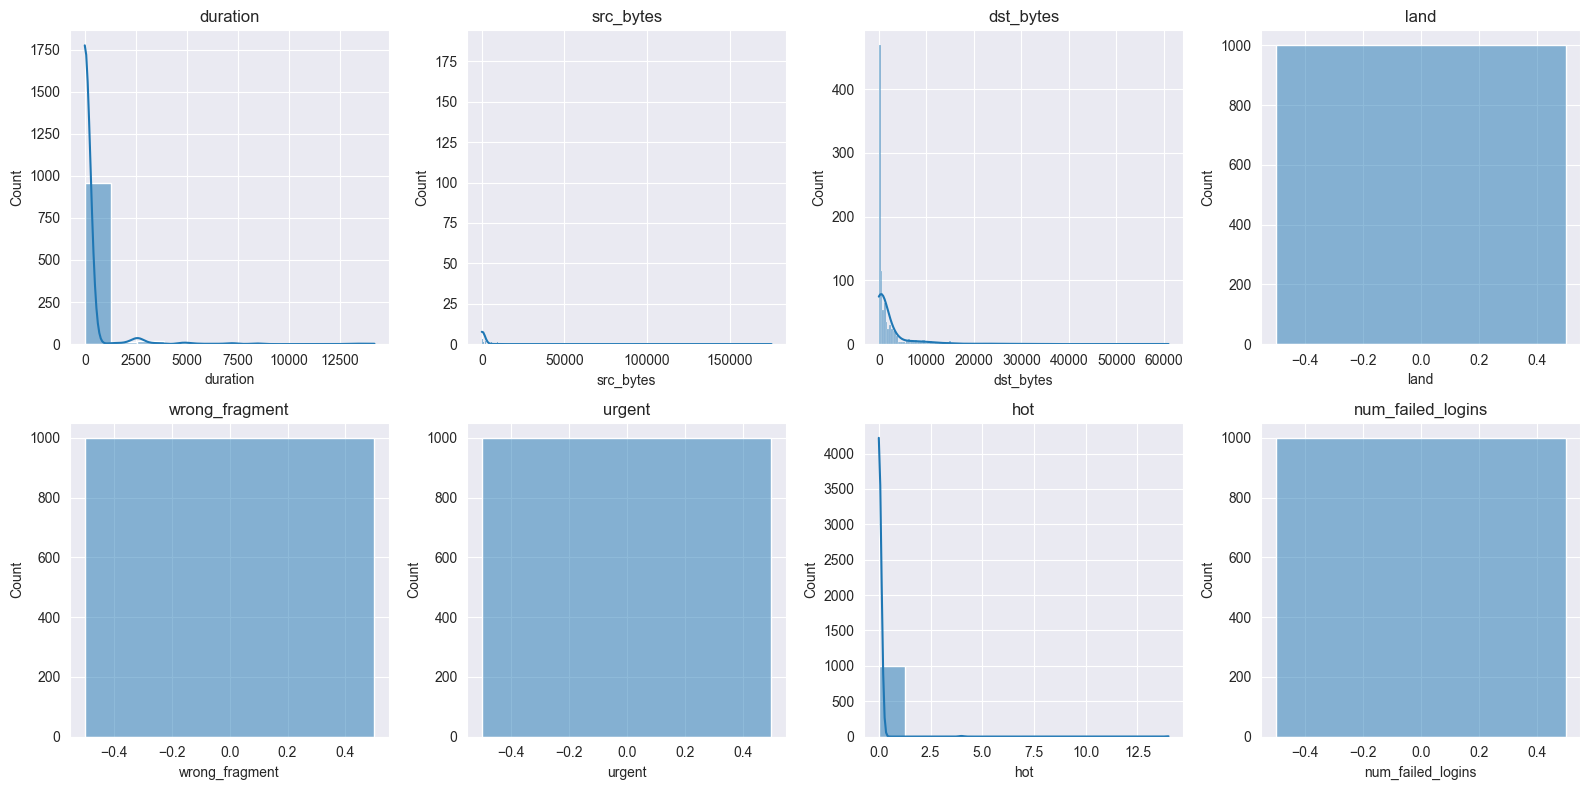

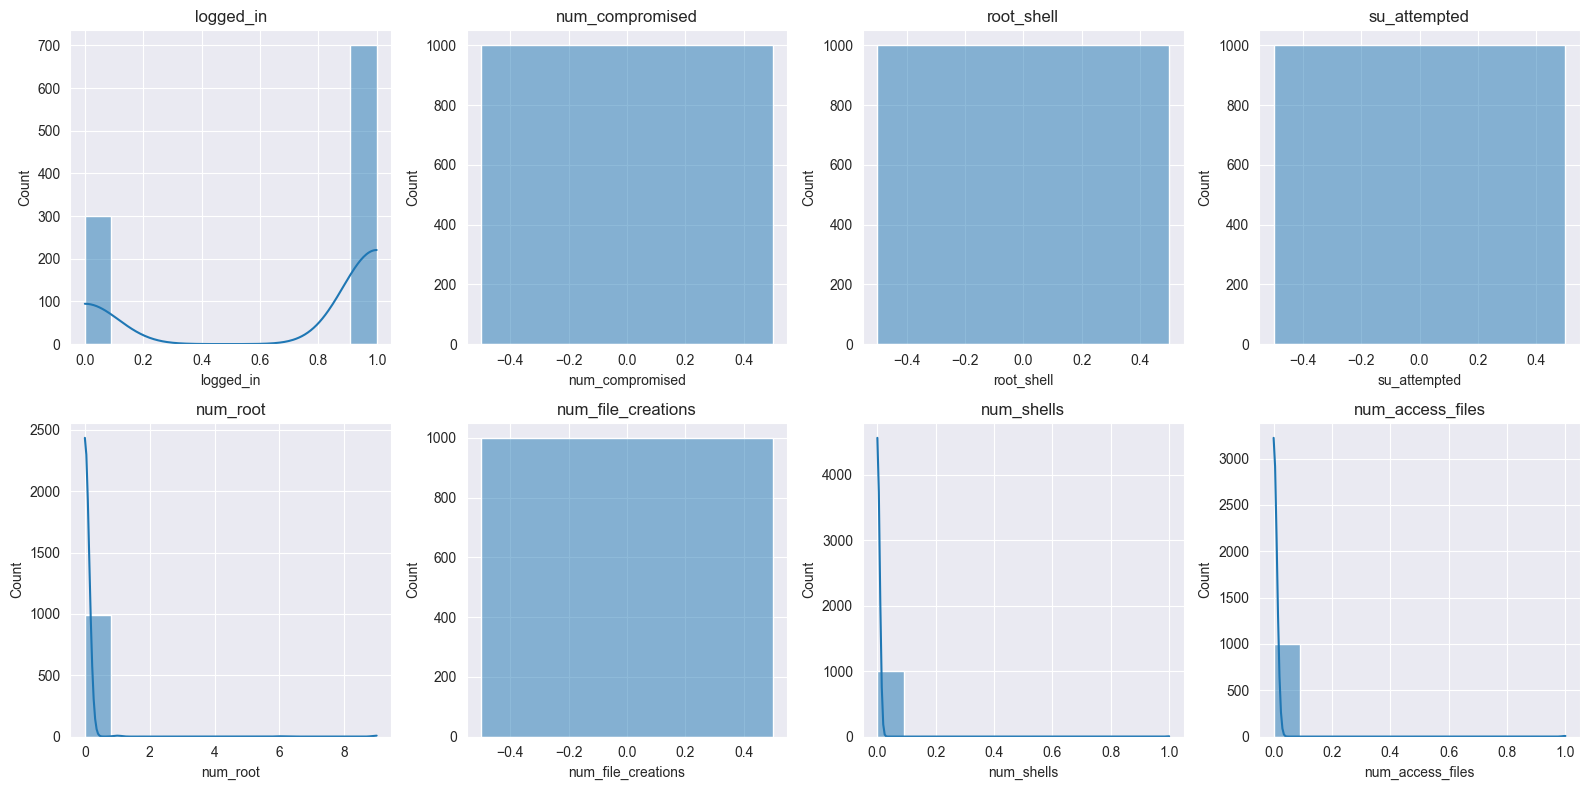

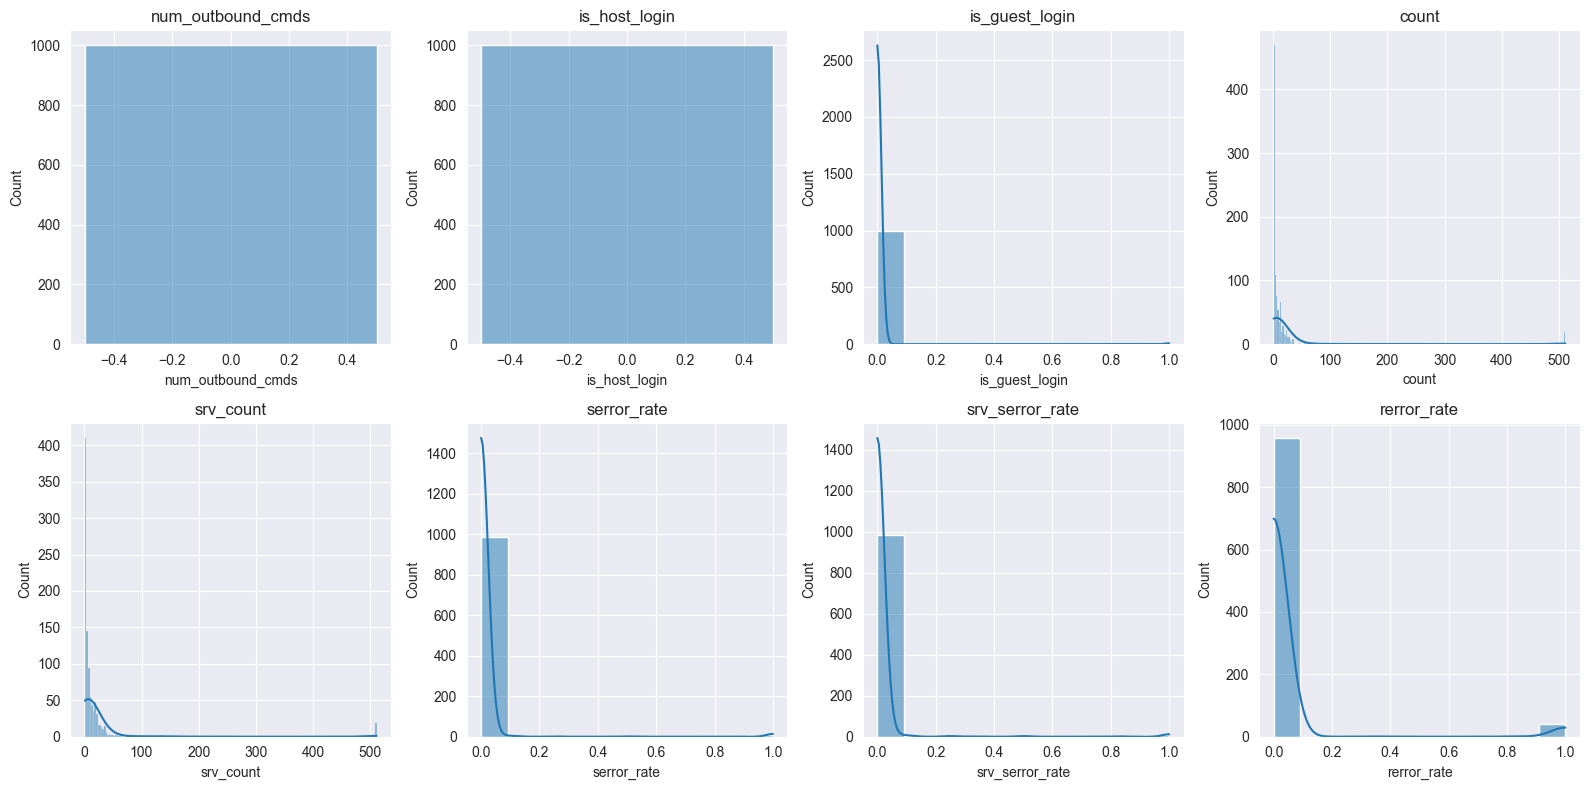

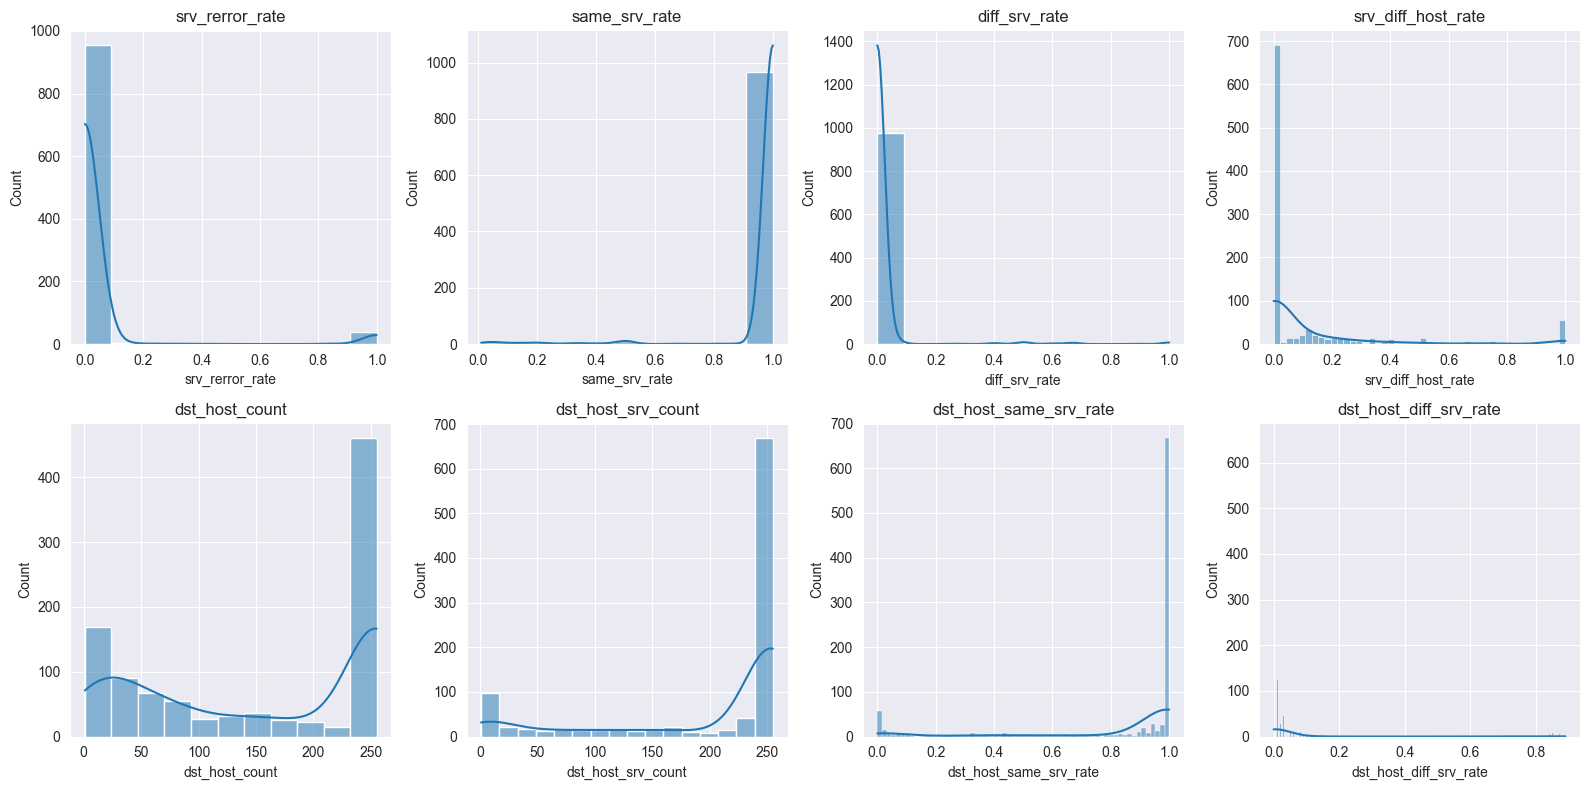

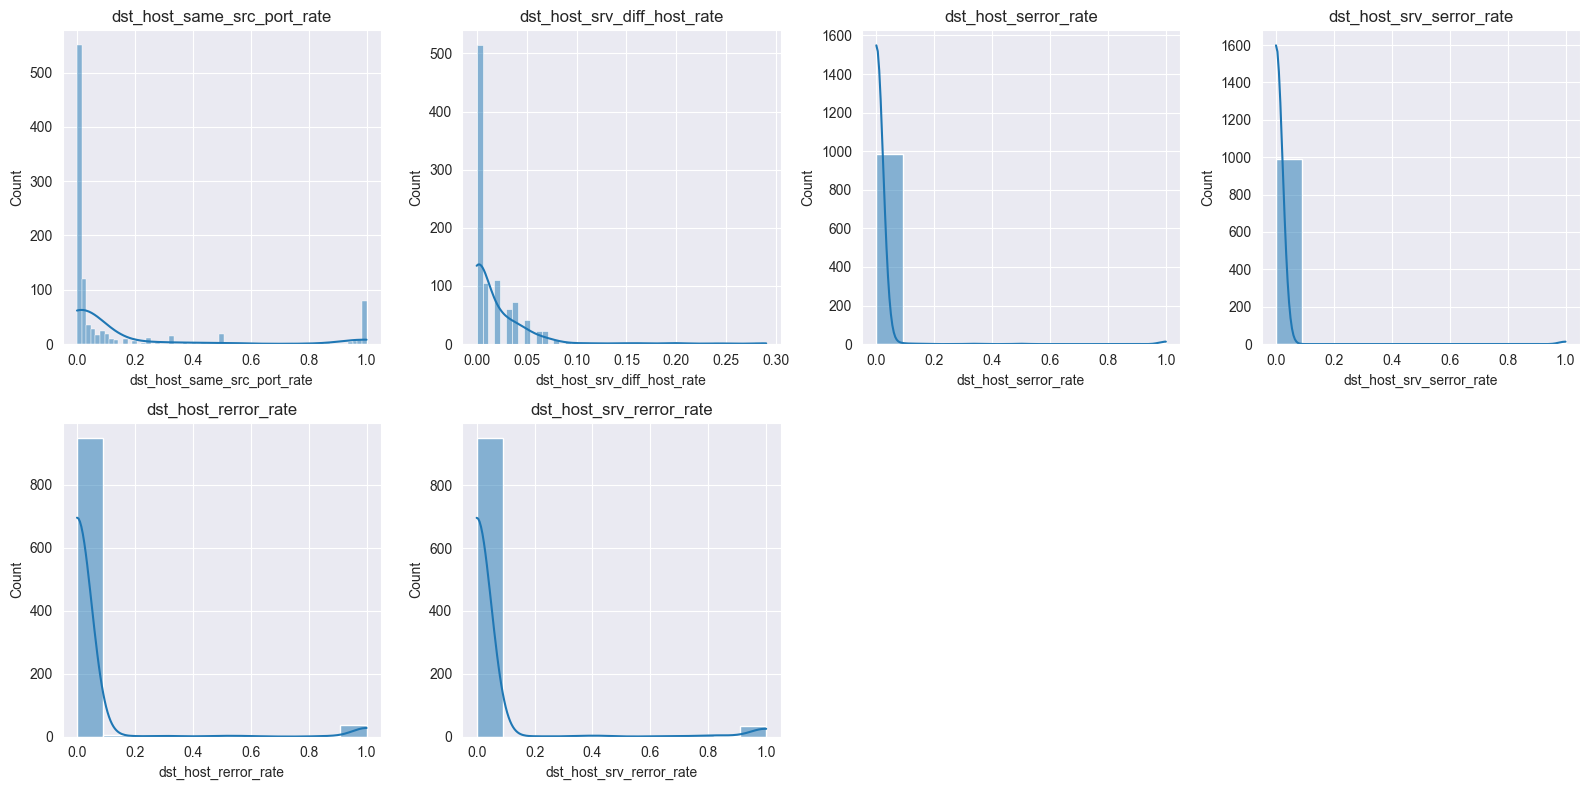

In [109]:
def show_numerical_feature_distribution(dataframe: pd.DataFrame):
    """
    Show in different figures the distribution of the numerical features.
    Create one figure for a group of 8 numerical features.
    :param dataframe: The dataset
    """
    numerical_features = dataframe.select_dtypes(include='number').columns
    for i in range(0, len(numerical_features), 8):
        plt.figure(figsize=(16, 8))
        for j, feature in enumerate(numerical_features[i:i + 8]):
            plt.subplot(2, 4, j + 1)
            sns.histplot(dataframe[feature], kde=True)
            plt.title(feature)
        plt.tight_layout()
        plt.show()

show_numerical_feature_distribution(X)

And we show the descriptive statistics of the numerical features.

In [110]:
numerical_features = X.select_dtypes(include='number').columns
for feature in numerical_features:
    print(f"Feature {feature}:\n", X[feature].describe(), "\n")

Feature duration:
 count     1000.000000
mean       195.214000
std       1100.503809
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      14205.000000
Name: duration, dtype: float64 

Feature src_bytes:
 count      1000.000000
mean        736.499000
std        6606.857823
min           0.000000
25%         146.000000
50%         229.000000
75%         313.000000
max      175337.000000
Name: src_bytes, dtype: float64 

Feature dst_bytes:
 count     1000.000000
mean      2329.335000
std       5334.095564
min          0.000000
25%        111.750000
50%        395.000000
75%       1920.000000
max      60990.000000
Name: dst_bytes, dtype: float64 

Feature land:
 count    1000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: land, dtype: float64 

Feature wrong_fragment:
 count    1000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%        

## ✨ Questions ✨

1. To which features can we apply Tukey's fences to detect outliers?
2. Why?
3. How can we detect outliers in the dataset?

### Answers

*Write your answers here.*


## Isolation forest

[Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) is an unsupervised multivariate learning algorithm to detect anomalies on data.

In [111]:
def apply_isolation_forest(df: pd.DataFrame) -> pd.Series:
    """
    Apply the Isolation Forest algorithm to detect outliers in the dataset.
    :param df: the dataset
    :return: a Series with 1 for outliers and 0 for inliers
    """
    iso_forest = IsolationForest(contamination=0.03, random_state=42)
    outliers = iso_forest.fit_predict(df)
    # Modify inliers 1 to 0 and outliers -1 to 1
    outliers[outliers == 1] = 0
    outliers[outliers == -1] = 1
    return outliers

y_if_outliers = apply_isolation_forest(X)
print(f"Isolation Forest outliers: {sum(y_if_outliers)}/{len(y_if_outliers)} samples "
      f"({sum(y_if_outliers)/len(y_if_outliers):.2f}%).")
print(f"Actual number of outliers: {sum(y)}/{len(y)} samples ({sum(y)/len(y):.2f}%).")

Isolation Forest outliers: 30/1000 samples (0.03%).
Actual number of outliers: 33/1000 samples (0.03%).


Let's compare the outliers detected by the Isolation Forest algorithm with the actual outliers in the dataset.

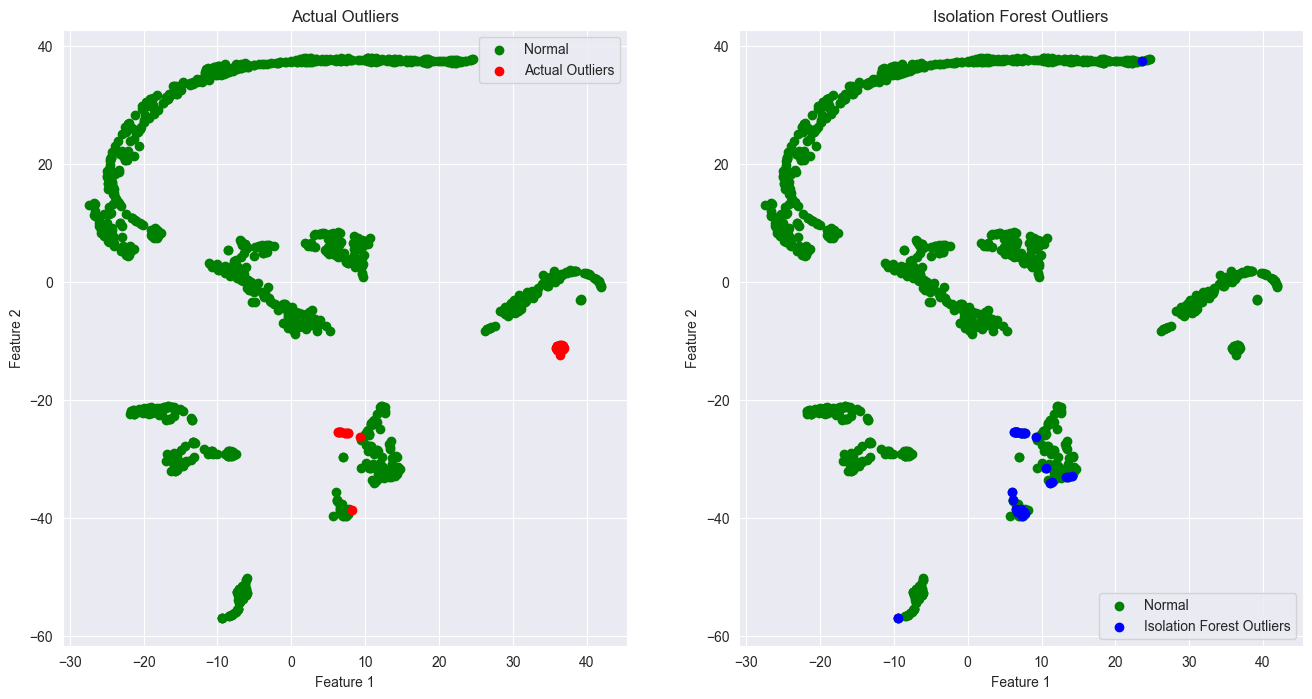

In [112]:
def plot_tsne(X_dataframe: pd.DataFrame, y_iso_outliers: np.array, y_actual_outliers: np.array) -> None:
    """
    Plot two figures: actual outliers (left) and Isolation Forest outliers (right).
    Plot the t-SNE of the dataset (all the points) on green in both plots.
    Left plot: those points with the y value in 1 (actual outliers) are plotted in red.
    Right plot: Those points in iso_outliers are plotted in blue (Isolation Forest) outliers.
    :param X_dataframe: All the dataset
    :param y_iso_outliers: Isolation Forest outliers
    :param y_actual_outliers: Actual outliers
    """
    tsne = TSNE(n_components=2, random_state=random_state)
    X_tsne = tsne.fit_transform(X_dataframe)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(X_tsne[y_actual_outliers == 0, 0], X_tsne[y_actual_outliers == 0, 1], c='green', label='Normal')
    plt.scatter(X_tsne[y_actual_outliers == 1, 0], X_tsne[y_actual_outliers == 1, 1], c='red', label='Actual Outliers')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Actual Outliers')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='green', label='Normal')
    plt.scatter(X_tsne[y_iso_outliers == 1, 0], X_tsne[y_iso_outliers == 1, 1], c='blue',
                label='Isolation Forest Outliers')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Isolation Forest Outliers')
    plt.legend()
    plt.show()

plot_tsne(X, y_if_outliers, y.values)

## ✨ Questions ✨

4. Is the Isolation Forest algorithm detecting the outliers well?
5. Modify the contamination parameter in the Isolation Forest algorithm to see if you can improve the results. What happens?
6. How can you evaluate the effectiveness of the Isolation Forest algorithm?
7. (activity) Compute that metric and show the result in our example. Check that it is consistent with your answer to question 5.

### Answers

*Write your answers here.*



In [113]:
# Activity

# Write the code of Activity 7 here

